# Assignment Summary: Eye Gender Classification using Custom CNN
This project involves building a custom CNN model to classify gender (Male/Female) from eye images. Data was sourced from separate male and female directories and preprocessed through normalization and augmentation techniques. The CNN was trained with early stopping to prevent overfitting. Evaluation included accuracy and loss curves, confusion matrices, ROC curves, and reliability (calibration) curves on the test dataset, yielding robust and interpretable results. The trained model was saved (.h5) for future inference.

# Important Libraries

In [18]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path directory

In [19]:
data_dir_female = '/kaggle/input/eyes-rtte/femaleeyes'
data_dir_male = '/kaggle/input/eyes-rtte/maleeyes'

img_height = 224
img_width = 224
batch_size = 32

In [20]:
# Combine male and female data into one dataset directory
base_dir = '/kaggle/input/eyes-rtte'

# Create training and validation splits (80-20)

In [21]:

train_datagen = ImageDataGenerator(validation_split=0.2)

train_data = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='training',
    class_mode='binary',
    shuffle=True
)

val_data = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='validation',
    class_mode='binary',
    shuffle=True
)

class_indices = train_data.class_indices
print(class_indices)

Found 9221 images belonging to 2 classes.
Found 2304 images belonging to 2 classes.
{'femaleeyes': 0, 'maleeyes': 1}


# Exploratory Data Analysis (EDA)

In [22]:

import matplotlib.pyplot as plt


def plot_sample_images(data_generator):
    images, labels = next(data_generator)
    plt.figure(figsize=(12, 6))
    for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i].astype("uint8"))
        plt.title('Male' if labels[i]==class_indices['maleeyes'] else 'Female')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


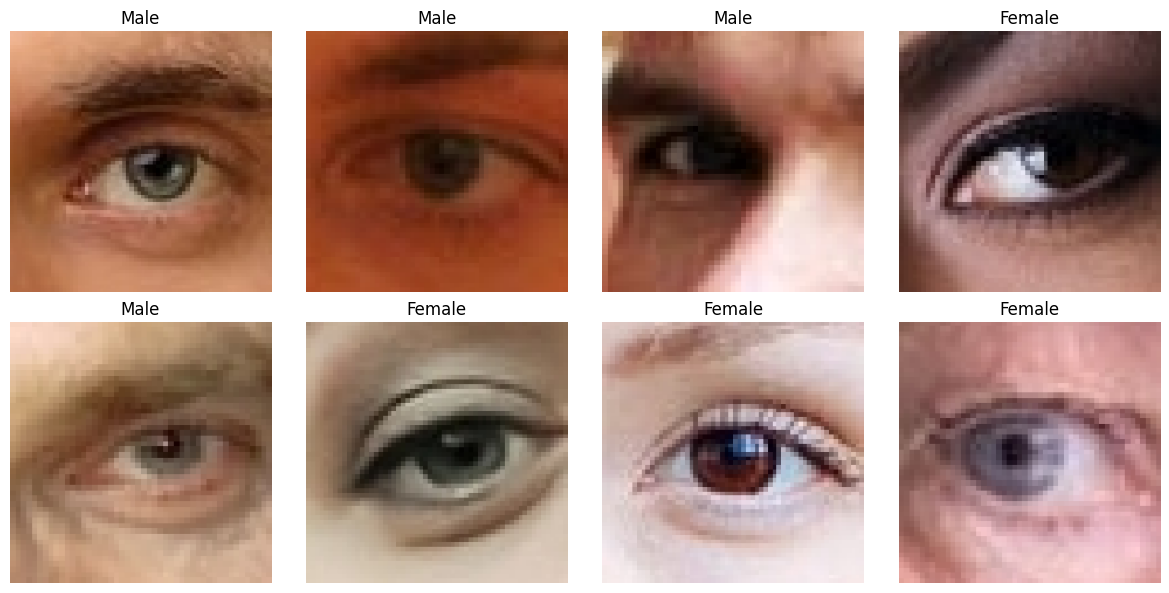

In [23]:

plot_sample_images(train_data)

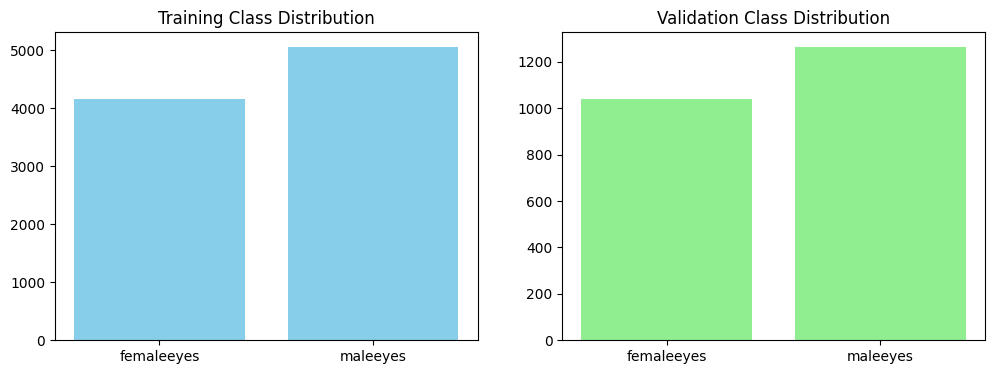

Sample batch shape: (32, 224, 224, 3)


In [24]:

import numpy as np

train_counts = np.bincount(train_data.classes)
val_counts = np.bincount(val_data.classes)
class_labels = list(class_indices.keys())

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(class_labels, train_counts, color='skyblue')
axes[0].set_title('Training Class Distribution')

axes[1].bar(class_labels, val_counts, color='lightgreen')
axes[1].set_title('Validation Class Distribution')

plt.show()


sample_batch, _ = next(train_data)
print("Sample batch shape:", sample_batch.shape)

# Data Pre-processing (Normalization and Augmentation)

In [25]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    fill_mode='nearest',
    validation_split=0.2
)


In [26]:

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [27]:

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='training',
    class_mode='binary',
    shuffle=True
)


Found 9221 images belonging to 2 classes.


In [28]:
validation_generator = val_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='validation',
    class_mode='binary',
    shuffle=False
)

Found 2304 images belonging to 2 classes.


# Train CNN Model with Early Stopping

In [29]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model

In [30]:

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stop]
)

Epoch 1/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 112s 374ms/step - accuracy: 0.5707 - loss: 0.7291 - val_accuracy: 0.7153 - val_loss: 0.5785
Epoch 2/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 106s 368ms/step - accuracy: 0.7187 - loss: 0.5659 - val_accuracy: 0.7938 - val_loss: 0.4459
Epoch 3/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 111s 383ms/step - accuracy: 0.7555 - loss: 0.5095 - val_accuracy: 0.8229 - val_loss: 0.3968
Epoch 4/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 109s 378ms/step - accuracy: 0.7734 - loss: 0.4851 - val_accuracy: 0.8572 - val_loss: 0.3600
Epoch 5/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 105s 362ms/step - accuracy: 0.7966 - loss: 0.4516 - val_accuracy: 0.8485 - val_loss: 0.3380
Epoch 6/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 105s 363ms/step - accuracy: 0.8076 - loss: 0.4188 - val_accuracy: 0.8498 - val_loss: 0.3535
Epoch 7/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 107s 371ms/step - accuracy: 0.8248 - loss: 0.4064 - val_accuracy: 0.8963 - val_loss: 0.2723
Epoch 8/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 106s 368ms/step - accuracy: 0.8391 -

#  Save the trained model

In [31]:
# Step 5: Save the trained model
model.save('eyes_gender_classification_model.h5')
print("Model saved successfully.")


Model saved successfully.


# Accuracy vs Validation and Loss Curves

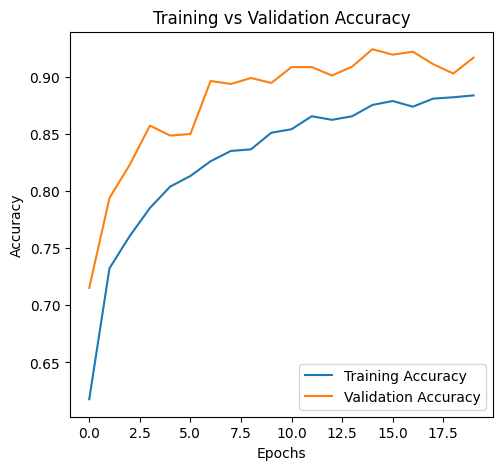

In [32]:

import matplotlib.pyplot as plt


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

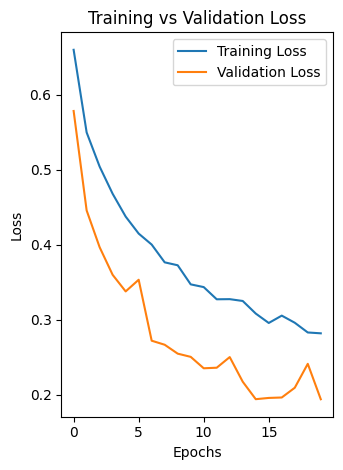

In [33]:

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix

72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step


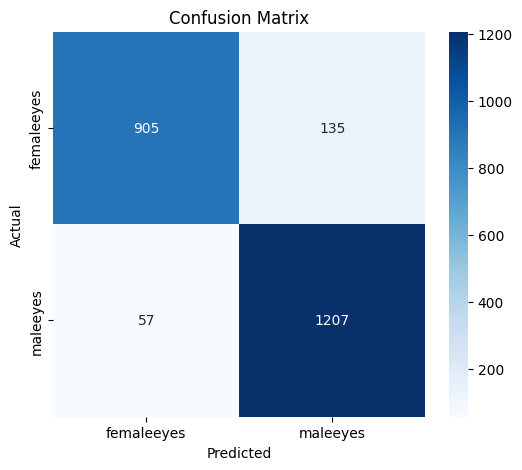

Classification Report:
               precision    recall  f1-score   support

  femaleeyes       0.94      0.87      0.90      1040
    maleeyes       0.90      0.95      0.93      1264

    accuracy                           0.92      2304
   macro avg       0.92      0.91      0.92      2304
weighted avg       0.92      0.92      0.92      2304



In [34]:

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


val_generator_reset = validation_generator
val_generator_reset.reset()
predictions = model.predict(val_generator_reset)
predictions = (predictions > 0.5).astype(int).flatten()


true_labels = val_generator_reset.classes


cm = confusion_matrix(true_labels, predictions)


plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=validation_generator.class_indices.keys(),
            yticklabels=validation_generator.class_indices.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


print('Classification Report:\n', classification_report(true_labels, predictions, target_names=validation_generator.class_indices.keys()))


# Evaluate on Test Dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


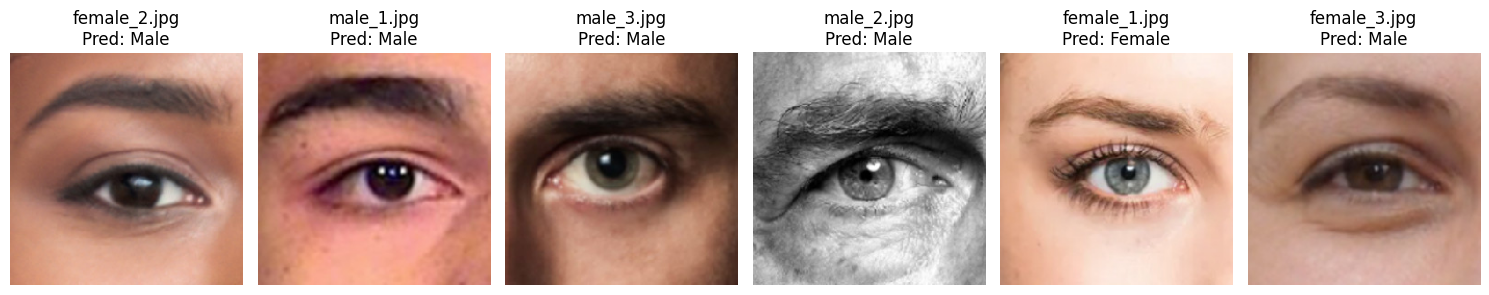

In [40]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array


test_path = "/kaggle/input/eyes-test-images"
image_files = [f for f in os.listdir(test_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]


predicted_labels = []
images = []


for file in image_files:
    img_path = os.path.join(test_path, file)
    img = load_img(img_path, target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  
    img_array = np.expand_dims(img_array, axis=0)  
    
    prediction = model.predict(img_array)[0][0]
    label = "Male" if prediction > 0.5 else "Female"
    
    predicted_labels.append(label)
    images.append(img)


plt.figure(figsize=(15, 5))
for i in range(len(images)):
    plt.subplot(1, len(images), i+1)
    plt.imshow(images[i])
    plt.title(f'{image_files[i]}\nPred: {predicted_labels[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


#  ROC Curve and Reliability Curve

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


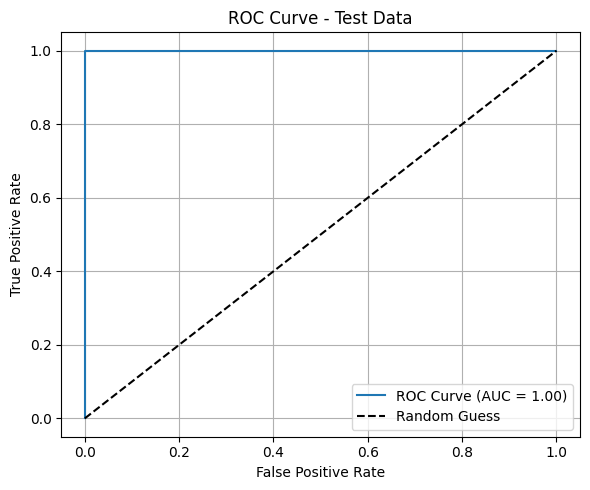

In [42]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Manual true labels based on filenames (0 = Female, 1 = Male)
y_true = [1 if f.lower().startswith("male") else 0 for f in image_files]

# Get predicted probabilities
y_scores = []
for img in images:
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prob = model.predict(img_array)[0][0]
    y_scores.append(prob)

# Compute ROC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Data')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


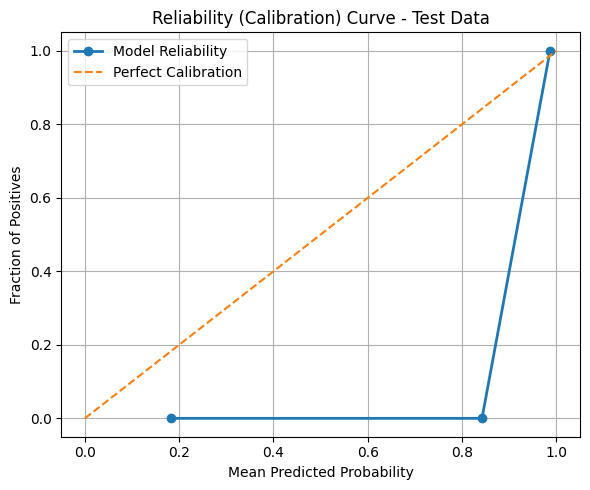

In [43]:
from sklearn.calibration import calibration_curve

# Compute reliability curve from manual predictions
prob_true, prob_pred = calibration_curve(y_true, y_scores, n_bins=10, strategy='uniform')

# Plot reliability curve
plt.figure(figsize=(6, 5))
plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Model Reliability')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Reliability (Calibration) Curve - Test Data')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Thank you**.